<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/cars_classification_effv2m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем dataset из kaggle

In [1]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle competitions download -c hse-cars-competition

100% 1.82G/1.82G [01:52<00:00, 22.9MB/s]
100% 1.82G/1.82G [01:52<00:00, 17.4MB/s]


In [ ]:
!unzip hse-cars-competition.zip

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

import numpy as np
import time
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm

matplotlib.style.use('ggplot')

In [5]:
train_ann = pd.read_csv('./annotation/train_ann.csv')

In [6]:
len(train_ann)

8132

In [7]:
train_ann.sample(3)

,imname,class
5788,train/4c27a689bdb49333d65bff4ec574fb0e.jpg,77
3806,train/f51249167d793f10e2d1cd1ea4a120a2.jpg,83
814,train/436c8ffaf914d140ad8ad225af131b4c.jpg,11


In [8]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cuda', index=0)

In [11]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(25, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=8),
        transforms.ToTensor(),
        transforms.ColorJitter(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [12]:
class CarsDataset(Dataset):
    """Cars dataset."""

    def __init__(self, root_dir, imlist, transform=None):
        """
        Arguments:
            imlist(pandas DataFrame): DataFrame with columns file_name, class
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.imlist = imlist
        self.transform = transform

    def __len__(self):
        return len(self.imlist)

    def __getitem__(self, idx):
        impath, target = self.imlist.loc[idx]
        full_imname = os.path.join(self.root_dir, impath)

        if not os.path.exists(full_imname):
            print('No file ', full_imname)
            pass

        img = Image.open(full_imname).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

In [25]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

Проверил на val, для каггла использую весь датасет

In [26]:
train_set = CarsDataset('./images',
                        train_ann,
                        transform=get_train_transform(IMAGE_SIZE))

val_set = CarsDataset('./images',
                      train_ann,
                      transform=get_valid_transform(IMAGE_SIZE))

In [27]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=True)

In [28]:
def save_model(epoch, model, optimizer, criterion, acc):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"model_epoch_{epoch}_acc{acc:.4f}.pth")

In [29]:
def training_plots(train_acc, valid_acc, train_loss, valid_loss):
    # Accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [30]:
def train(model, loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [31]:
def validate(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [32]:
def build_model(pretrained=True, fine_tune=True, num_classes=196):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')

    model = models.efficientnet_v2_m(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [33]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [39]:
# Learning_parameters
lr = 1e-4
weight_decay = 0.00001
epochs = 50

In [40]:
# Load the model
model = build_model().to(device)

# Total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Loss function
criterion = LabelSmoothingCrossEntropy()

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                 T_max=len(train_loader)*epochs,
                                                 eta_min=1e-6)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
53,109,432 total parameters
53,109,432 training parameters


In [ ]:
# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 patience=3,
                                                 threshold=0.9,
                                                 min_lr=1e-6,
                                                 verbose=True)

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 4.732, training acc: 6.628
Validation loss: 3.294, validation acc: 34.026
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[INFO]: Epoch 2 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 2.937, training acc: 40.273
Validation loss: 1.772, validation acc: 75.996
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.907, training acc: 71.077
Validation loss: 1.279, validation acc: 91.109
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.478, training acc: 84.702
Validation loss: 1.126, validation acc: 95.032
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.273, training acc: 91.072
Validation loss: 1.033, validation acc: 97.319
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.166, training acc: 94.011
Validation loss: 0.990, validation acc: 98.082
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.102, training acc: 96.053
Validation loss: 0.964, validation acc: 98.955
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.057, training acc: 97.135
Validation loss: 0.947, validation acc: 98.930
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.043, training acc: 97.430
Validation loss: 0.945, validation acc: 98.979
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.020, training acc: 97.983
Validation loss: 0.929, validation acc: 99.139
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.008, training acc: 98.143
Validation loss: 0.917, validation acc: 99.656
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.995, training acc: 98.475
Validation loss: 0.919, validation acc: 99.139
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.979, training acc: 98.451
Validation loss: 0.911, validation acc: 99.484
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.987, training acc: 98.328
Validation loss: 0.911, validation acc: 99.594
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.979, training acc: 98.414
Validation loss: 0.901, validation acc: 99.742
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.963, training acc: 99.016
Validation loss: 0.904, validation acc: 99.447
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.966, training acc: 98.598
Validation loss: 0.908, validation acc: 99.410
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.962, training acc: 98.610
Validation loss: 0.902, validation acc: 99.520
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.953, training acc: 99.016
Validation loss: 0.894, validation acc: 99.582
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.956, training acc: 98.733
Validation loss: 0.906, validation acc: 99.434
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.959, training acc: 98.672
Validation loss: 0.901, validation acc: 99.520
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.946, training acc: 98.783
Validation loss: 0.891, validation acc: 99.668
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.938, training acc: 98.918
Validation loss: 0.887, validation acc: 99.766
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.929, training acc: 99.213
Validation loss: 0.890, validation acc: 99.594
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.937, training acc: 98.992
Validation loss: 0.888, validation acc: 99.520
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.943, training acc: 98.795
Validation loss: 0.882, validation acc: 99.889
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.920, training acc: 99.287
Validation loss: 0.882, validation acc: 99.791
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.930, training acc: 99.029
Validation loss: 0.888, validation acc: 99.606
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.930, training acc: 99.176
Validation loss: 0.884, validation acc: 99.693
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.940, training acc: 98.610
Validation loss: 0.885, validation acc: 99.594
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.929, training acc: 99.029
Validation loss: 0.881, validation acc: 99.742
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.924, training acc: 99.029
Validation loss: 0.878, validation acc: 99.779
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.927, training acc: 98.967
Validation loss: 0.881, validation acc: 99.705
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.907, training acc: 99.533
Validation loss: 0.874, validation acc: 99.865
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.908, training acc: 99.348
Validation loss: 0.874, validation acc: 99.816
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.922, training acc: 98.930
Validation loss: 0.877, validation acc: 99.791
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.911, training acc: 99.397
Validation loss: 0.876, validation acc: 99.754
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.921, training acc: 98.955
Validation loss: 0.879, validation acc: 99.729
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.915, training acc: 99.164
Validation loss: 0.883, validation acc: 99.582
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.925, training acc: 98.955
Validation loss: 0.874, validation acc: 99.828
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.923, training acc: 98.992
Validation loss: 0.879, validation acc: 99.742
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.917, training acc: 99.176
Validation loss: 0.873, validation acc: 99.889
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.908, training acc: 99.225
Validation loss: 0.874, validation acc: 99.693
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.912, training acc: 99.127
Validation loss: 0.872, validation acc: 99.840
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.911, training acc: 99.201
Validation loss: 0.874, validation acc: 99.816
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.906, training acc: 99.213
Validation loss: 0.872, validation acc: 99.852
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.910, training acc: 99.262
Validation loss: 0.874, validation acc: 99.816
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.908, training acc: 99.274
Validation loss: 0.871, validation acc: 99.852
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.910, training acc: 99.065
Validation loss: 0.874, validation acc: 99.742
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 0.902, training acc: 99.348
Validation loss: 0.871, validation acc: 99.803
--------------------------------------------------
TRAINING COMPLETE


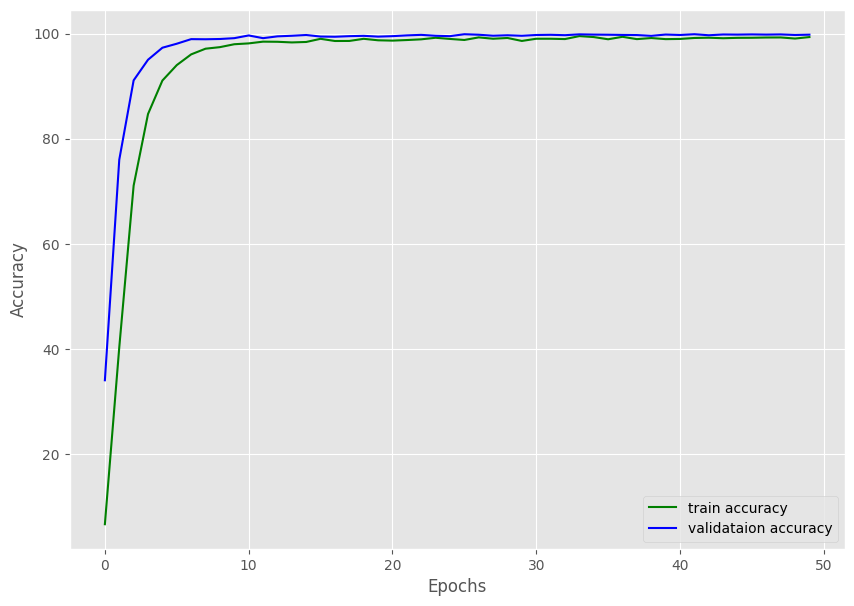

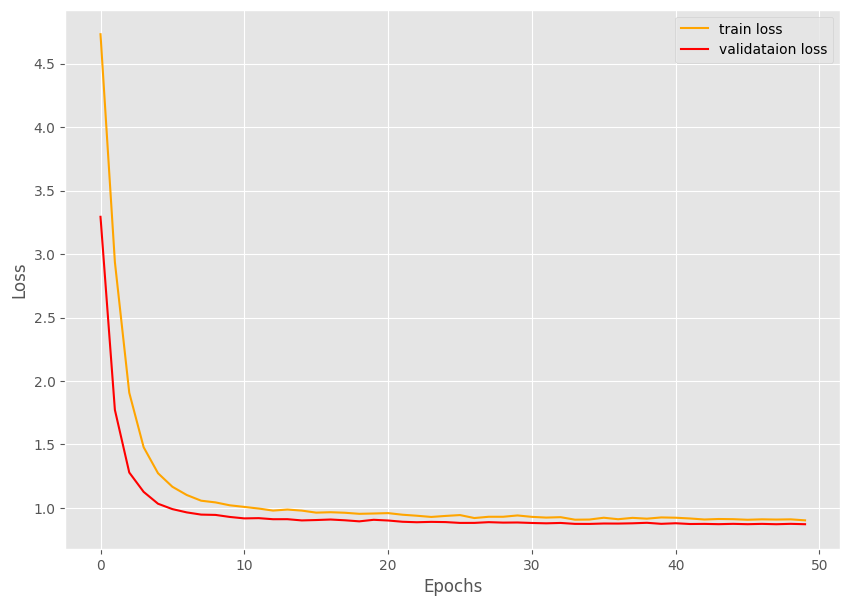

In [41]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    if scheduler is not None:
        scheduler.step(valid_epoch_acc)

    save_model(epoch, model, optimizer, criterion, valid_epoch_acc)


# Save the loss and accuracy plots.
training_plots(train_acc, valid_acc, train_loss, valid_loss)

print('TRAINING COMPLETE')

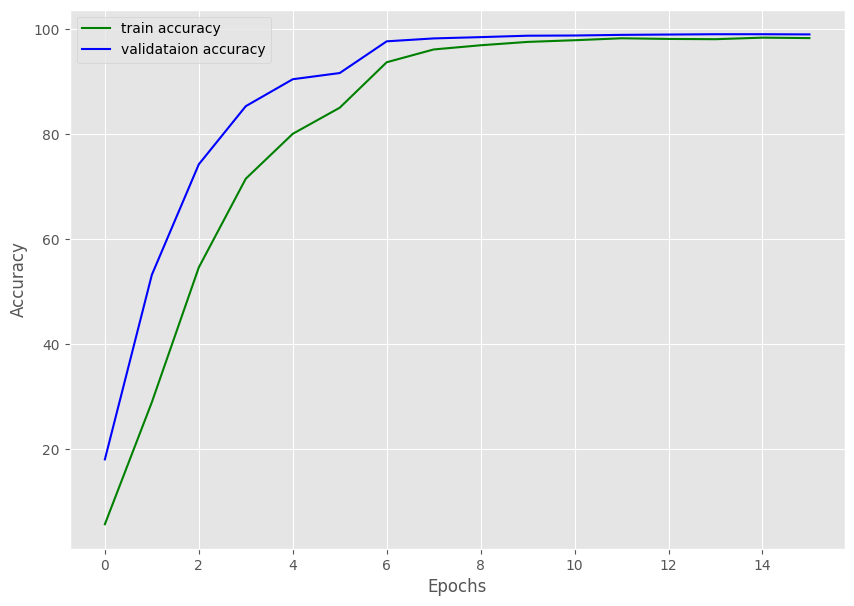

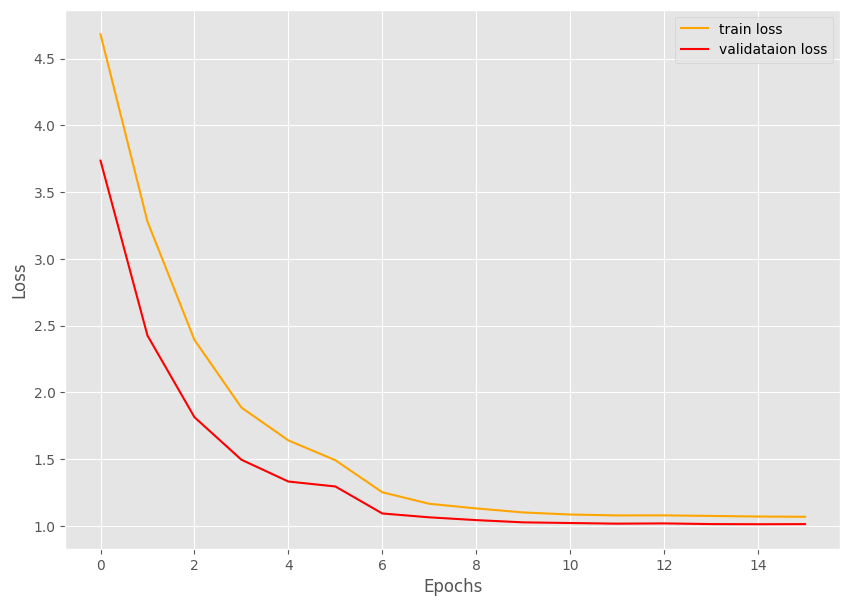

In [ ]:
training_plots(train_acc, valid_acc, train_loss, valid_loss)

In [ ]:
model_pth = './model_epoch_14_acc98.9670.pth'

#checkpoint = torch.load(model_pth, map_location=torch.device('cpu'))
checkpoint = torch.load(model_pth)

model = build_model().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

[INFO]: Loading pre-trained weights


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Fine-tuning all layers...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [42]:
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [43]:
test_dir = './images/test'
test_images = sorted(os.listdir('./images/test'))

predicts = []

for i in tqdm(range(len(test_images))):
    full_imname = os.path.join(test_dir, test_images[i])
    image = Image.open(full_imname)

    tranforms = get_valid_transform(IMAGE_SIZE)
    try:
      input_tensor = tranforms(image)
    except:
      image = image.convert('RGB')
      input_tensor = tranforms(image)

    input_batch = input_tensor.unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_batch)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)
    predicts.append(predicted_class.item())

  0%|          | 0/8033 [00:00<?, ?it/s]

In [44]:
test_images = ['test/' + imname for imname in test_images]

In [45]:
csv_name = 'model_eff_v2m_50_epoch_acc_99_8032.csv'
df = pd.DataFrame({'new_name': test_images, 'class': predicts})

with open(csv_name, 'w') as csv_file:
  df.to_csv(path_or_buf=csv_file,
            index=False,
            header=['new_name', 'class'],
            columns=['new_name', 'class'])